In [32]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, RobustScaler

import pandas_profiling as pp

from imblearn.over_sampling  import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics  import classification_report_imbalanced
from sklearn.metrics   import classification_report
from sklearn.pipeline  import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.utils     import shuffle


In [7]:
def myscore(y_test, pred, proba, pr_curve=0, auc_curve=0): # Binary 분류 기준
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='macro')
    recall = recall_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    #auc = roc_auc_score(y_test, proba, average='macro', multi_class='ovr')
    print(f'Accuracy:{accuracy:.6f}, Precision:{precision:.6f}, Recall:{recall:.6f}, F1:{f1:.6f}')#', AUC:{auc:.6f}')
    mtx = confusion_matrix(y_test, pred)
    print(mtx)
    if pr_curve==1:
        mycurve(y_test, proba)
    if auc_curve==1:
        mycurve_auc(y_test, proba)

In [8]:
def mysplit(df, test_size=0.3) :
    df_X = df.iloc[:, :-1]
    df_y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=test_size, random_state=0, stratify=df_y)   #------Stratified 기반 분할
    return  X_train, X_test, y_train, y_test

In [9]:
from sklearn.metrics import precision_recall_curve
def mycurve(y_test, proba):  
    precision, recall, thresholds = precision_recall_curve(y_test, proba[ : , -1])
    print(len(precision), len(recall), len(thresholds))  #66 66 65
    plt.plot(thresholds, precision[:len(thresholds)], label="precision")
    plt.plot(thresholds, recall[:len(thresholds)], label="recall")
    plt.xlabel("thresholds")
    plt.ylabel("score")
    plt.grid()
    plt.legend()
    plt.show()

In [10]:
def myoutlier(df=None, column=None, weight=1.5):
    df = df[df['Class']==1][column]
    p25 = np.percentile(df.values, 25)
    p75 = np.percentile(df.values, 75)
    IQR = (p75 - p25) * weight
    low_limit  = p25 - IQR
    high_limit = p75 + IQR
    outlier_idx = df[(df < low_limit) | (df > high_limit)].index.values.tolist()
    return outlier_idx

In [34]:
def mycurve_auc(y_test, proba):  
    fpr, tpr, thresholds = roc_curve(y_test, proba[:,-1])
    print(len(fpr), len(tpr), len(thresholds))  #66 66 65
    plt.plot(fpr, tpr, label="roc")
    plt.plot([0,1], [0,1], label="th:0.5")
    plt.xlabel("FPR (1-TNR(specificity)")      #FP
    plt.ylabel("TPR (recall,sensitivity)") #TP
    plt.title(f"auc : {roc_auc_score(y_test, proba[:,-1]):.4f}")
    plt.grid()
    plt.legend()
    plt.show()

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA


pca_res = PCA(n_components=6, random_state=100).fit_transform(df.values)
pca_df = pd.DataFrame(data=pca_res, columns=['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6'])
pca_df['target'] = df['Class']

pca_df_y = pca_df.iloc[:,-1]
pca_df_X = pca_df.iloc[:,:-1]

In [12]:
df = pd.read_csv('creditcard.csv')

In [13]:
#df.info()

In [14]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

<AxesSubplot:xlabel='Class', ylabel='count'>

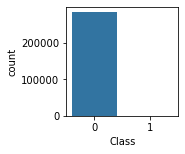

In [16]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.countplot('Class', data=df, ax=ax)

In [17]:
oh_numeric_feature = []
for col in df.columns:
    if df[col].nunique() <= 40:
        print(col, df[col].unique())
        oh_numeric_feature.append(col)

Class [0 1]


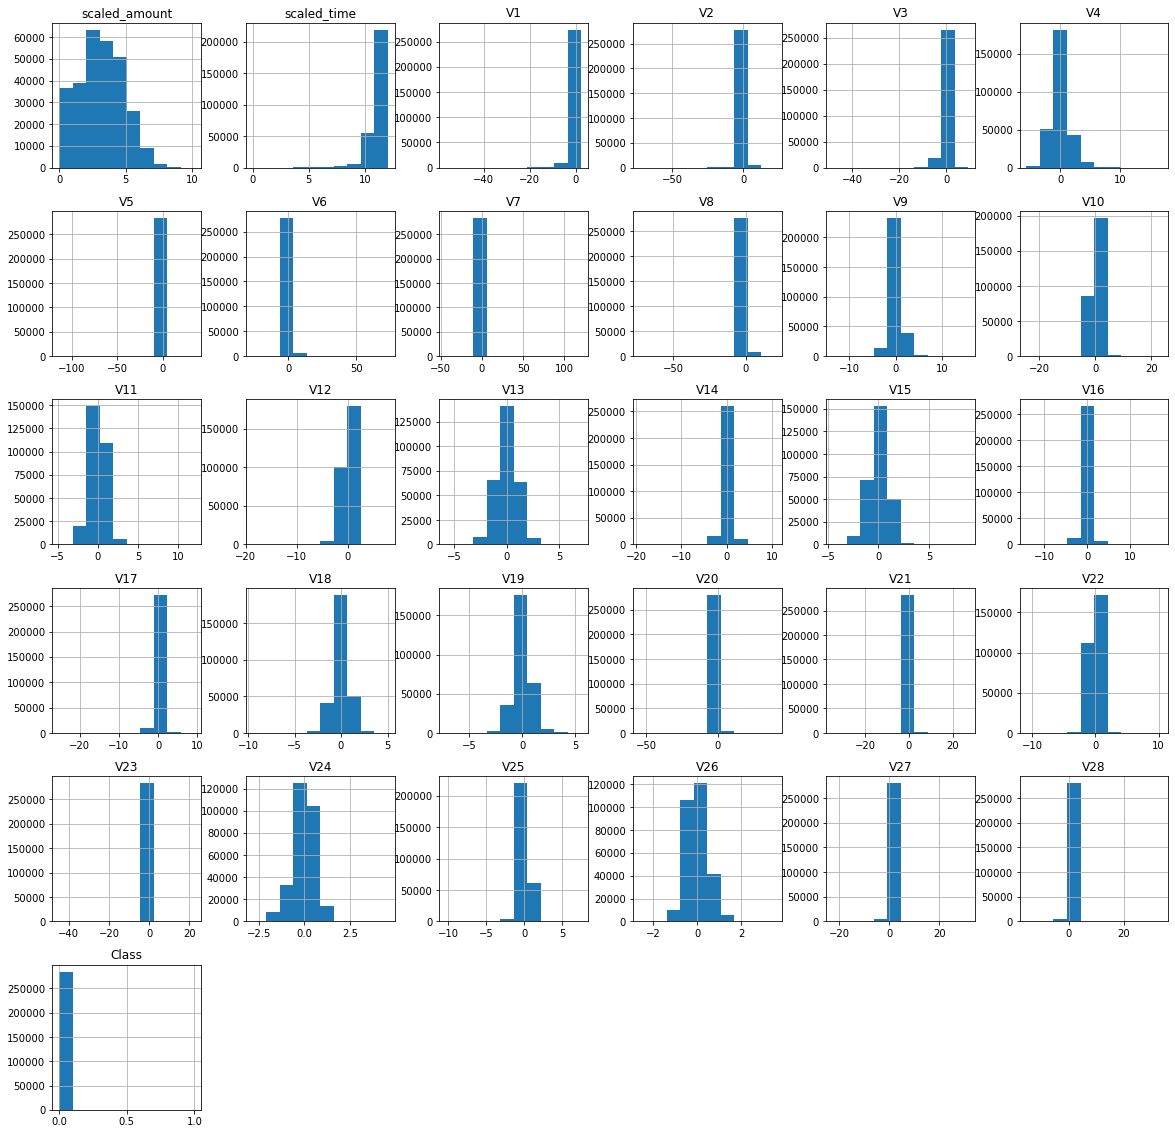

In [85]:
df.hist(figsize=(20,20))
plt.show()

### 제로 데이터 확인

In [18]:
nan_dict = {"CNT":df.isin([0]).sum(),
            "RATE": df.isin([0]).sum()/df.shape[0] *100
}
nan_df = pd.DataFrame(nan_dict)
print(nan_df[nan_df["RATE"]>0].sort_values("CNT", ascending=False))

           CNT       RATE
Class   284315  99.827251
Amount    1825   0.640785
Time         2   0.000702


### Missing Value 확인

In [19]:
# df.isna().sum()>0
nan_dict = {"CNT":df.isna().sum(),
            "RATE": df.isna().sum()/df.shape[0] *100
}
nan_df = pd.DataFrame(nan_dict)
print(nan_df[nan_df["RATE"]>0].sort_values("CNT", ascending=False))

Empty DataFrame
Columns: [CNT, RATE]
Index: []


### 상관분석

<AxesSubplot:>

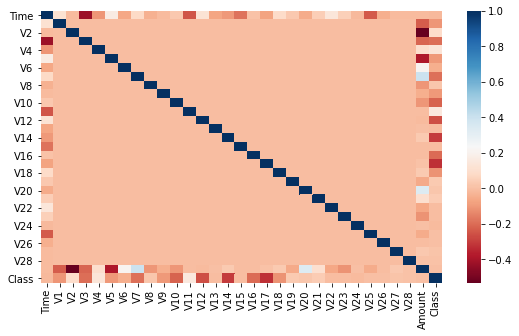

In [20]:
plt.figure(figsize=(9, 5))
sns.heatmap(df.corr(), cmap='RdBu')  #under_df.corr()

In [21]:
df.corrwith(df["Class"]).sort_values(ascending=False)

Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
dtype: float64

### Outlier 확인 - IQR

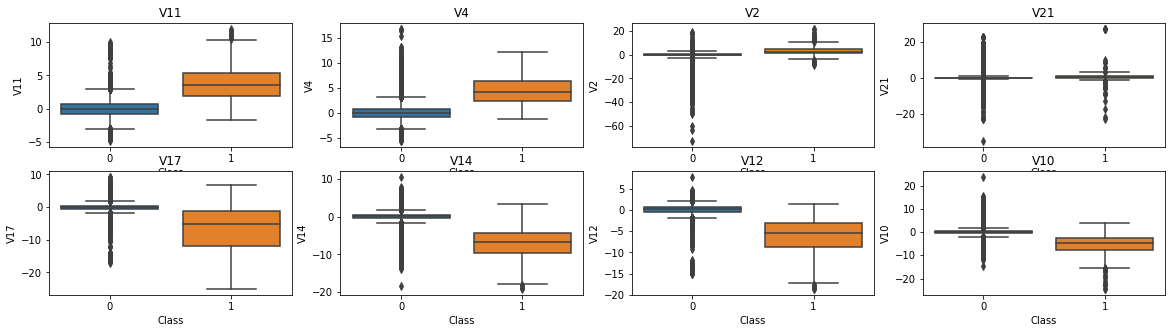

In [22]:
positive=['V11', 'V4', 'V2', 'V21']
negative=['V17', 'V14', 'V12', 'V10'] #, 'V16']
pos_neg = positive + negative
# print(cols)
f, axes = plt.subplots(2,4, figsize=(20,5))
# sns.boxplot(x="Class", y=col, data=df, ax=axes[0][0])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[0][1])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[0][2])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[0][3])

# sns.boxplot(x="Class", y=col, data=df, ax=axes[1][0])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[1][1])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[1][2])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[1][3])

for i, feature in enumerate(pos_neg):
    cols = i%4
    rows = i//4     
    sns.boxplot(x="Class", y=feature, data=df, ax=axes[rows][cols])
    axes[rows][cols].set_title(feature)

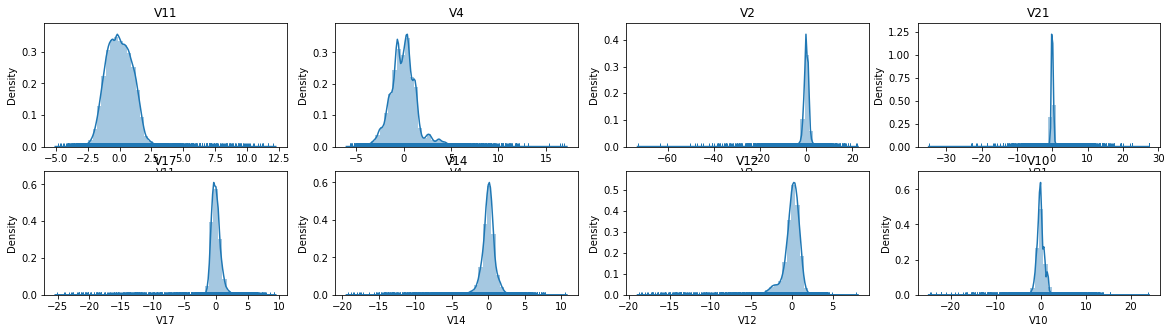

In [23]:
positive=['V11', 'V4', 'V2', 'V21']
negative=['V17', 'V14', 'V12', 'V10'] #, 'V16']
pos_neg = positive + negative
# print(cols)
f, axes = plt.subplots(2,4, figsize=(20,5))
for i, feature in enumerate(pos_neg):
    cols = i%4
    rows = i//4     
    sns.distplot(df[feature], kde=True, rug=True, ax=axes[rows][cols])
    axes[rows][cols].set_title(feature)

In [24]:
# col_idx = myoutlier(df=df, column='V11', weight=1.5)
for col in pos_neg:
    res = myoutlier(df=df, column=col, weight=1.5)
    print(col,  len(res), "\t\t", res)

V11 10 		 [8296, 8335, 8615, 9035, 9179, 9252, 9487, 9509, 10568, 10801]
V4 0 		 []
V2 46 		 [14211, 15166, 15204, 15225, 15451, 15476, 15506, 15539, 15566, 15736, 15751, 15781, 15810, 16780, 17317, 17366, 17407, 17453, 17480, 33276, 82400, 83297, 102441, 102442, 102443, 102444, 102445, 102446, 151006, 151007, 151008, 151009, 151462, 151519, 152223, 152295, 153823, 153835, 154234, 154371, 154587, 154684, 176049, 249607, 258403, 274382]
V21 49 		 [10801, 10891, 10897, 11343, 11710, 11841, 11880, 12070, 12108, 12261, 12369, 42958, 43204, 44223, 44270, 77682, 102441, 102442, 102443, 102444, 102445, 102446, 144754, 149145, 149600, 151006, 151007, 151008, 151009, 151011, 151462, 151519, 151730, 151807, 152019, 152223, 152295, 153823, 153835, 153885, 154234, 154371, 154587, 154684, 167184, 167305, 189878, 231978, 272521]
V17 0 		 []
V14 4 		 [8296, 8615, 9035, 9252]
V12 6 		 [8296, 8615, 150601, 150644, 150647, 150654]
V10 19 		 [44223, 44270, 150679, 150680, 150697, 151006, 151007, 151008, 

### Time Amount 확인

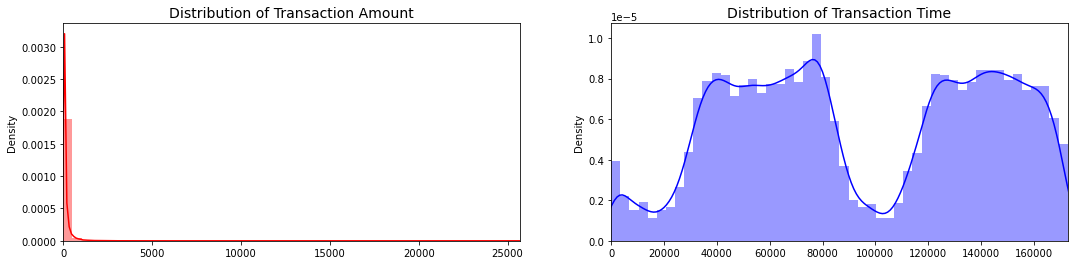

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

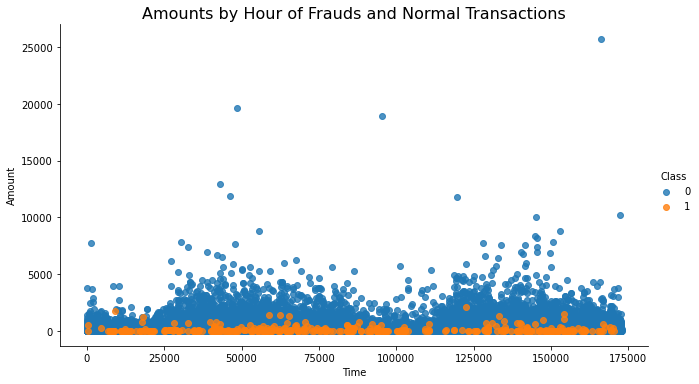

In [26]:
ax = sns.lmplot(y="Amount", x="Time", fit_reg=False, aspect=1.8, data=df, hue='Class')
plt.title("Amounts by Hour of Frauds and Normal Transactions", fontsize=16)
plt.show()

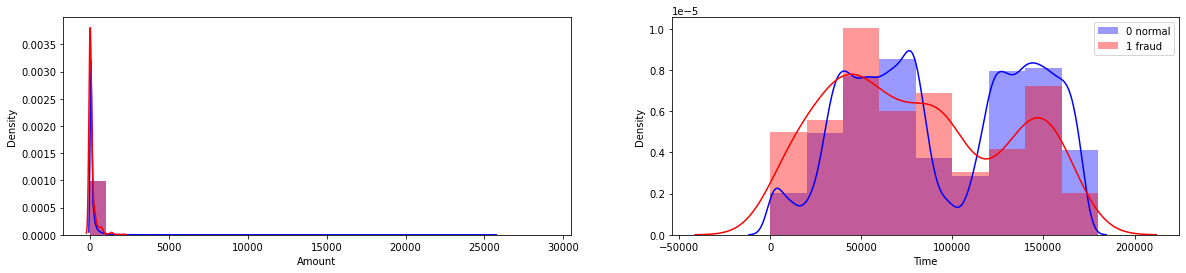

In [27]:
fig, axes = plt.subplots(figsize=(20, 4), ncols=2)
# plt.xticks(range(0, 30000, 1000), rotation=60)

bins = np.arange(0, 30000, 1000)
sns.distplot(df[df['Class']==0]['Amount'] , ax=axes[0], bins=bins, color='b', label='0 normal')
sns.distplot(df[df['Class']==1]['Amount'] , ax=axes[0], bins=bins, color='r', label='1 fraud')

bins = np.arange(0, 200000, 20000)
sns.distplot(df[df['Class']==0]['Time'] , ax=axes[1], bins=bins, color='b', label='0 normal')
sns.distplot(df[df['Class']==1]['Time'] , ax=axes[1], bins=bins, color='r', label='1 fraud')

plt.legend()
plt.show()

### 데이터 전처리

In [28]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
# X_train['T_Amount'] = scaler.fit_transform(X_train['Amount'].values.reshape(-1, 1))
# X_test['T_Amount'] = scaler.transform(X_test['Amount'].values.reshape(-1, 1))       #------------fit안함..주의주의
sacler_val = std_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df.insert(0, 'T_Amount', sacler_val)

sacler_val = np.log1p(df['Amount'])
df.insert(0, 'T_Amount2', sacler_val)

df.drop(['Time','Amount', 'T_Amount'], axis=1, inplace=True)


### 일단 점수 확인

(199364, 29) (85443, 29) 199364 85443
Accuracy:0.999122, Precision:0.959372, Recall:0.770229, F1:0.840206
[[85288     7]
 [   68    80]]
53867 53867 53866


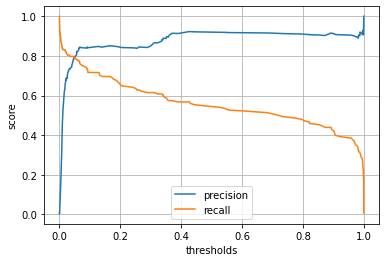

1627 1627 1627


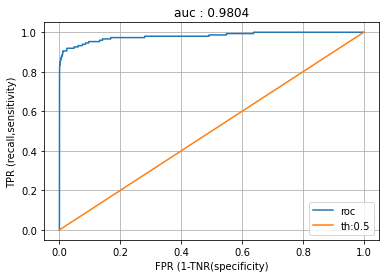

In [69]:
X_train, X_test, y_train, y_test = mysplit(df)
print(X_train.shape, X_test.shape, len(y_train), len(y_test))

lr = LogisticRegression(random_state = 100)
lr.fit(X_train,y_train)
pred_lr = lr.predict(X_test)
proba_lr = lr.predict_proba(X_test)
myscore(y_test, pred_lr, proba_lr, pr_curve=1, auc_curve=1)

Accuracy:0.999157, Precision:0.874801, Recall:0.884912, F1:0.879789
[[85257    38]
 [   34   114]]
3 3 2


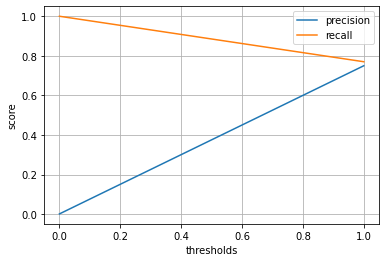

3 3 3


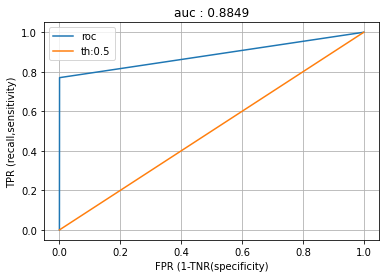

In [67]:
dt = DecisionTreeClassifier(random_state = 100) # precision-recall 교차X -> 임계영역 조절 불가
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
proba_dt = dt.predict_proba(X_test)
myscore(y_test, pred_dt, proba_dt, pr_curve=1, auc_curve=1)

In [68]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.92      0.54      0.68       148

    accuracy                           1.00     85443
   macro avg       0.96      0.77      0.84     85443
weighted avg       1.00      1.00      1.00     85443



### 언더샘플링 - NearMiss

In [77]:
X_train, X_test, y_train, y_test = mysplit(df)
X_train_NearMiss, y_train_NearMiss = NearMiss().fit_resample(X_train, y_train) # dataframe
X_test_NearMiss, y_test_NearMiss   = NearMiss().fit_resample(X_test, y_test)

print(X_train_NearMiss.shape)
print(X_test_NearMiss.shape)



(688, 29)
(296, 29)


In [54]:
X_train, X_test, y_train, y_test = mysplit(df)
X_train_NearMiss, y_train_NearMiss = NearMiss().fit_resample(X_train.values, y_train.values) #array
X_test_NearMiss, y_test_NearMiss   = NearMiss().fit_resample(X_test.values, y_test.values)
y, counts = np.unique(y_train_NearMiss, return_counts=True)
print(y, counts)
y, counts = np.unique(y_test_NearMiss, return_counts=True)
print(y, counts)


[0 1] [344 344]
[0 1] [148 148]


### 언더샘플링 - Shuffle

In [93]:
# Shuffle 언더프레임
df = df.sample(frac=1)   #shuffle
df1 = df.loc[df['Class'] == 1]
df0 = df.loc[df['Class'] == 0][:len(df1)] # -> len으로 같은 데이터 복제
under_df_f1f0 = pd.concat([df1, df0])
under_df = under_df_f1f0.sample(frac=1, random_state=100)

<AxesSubplot:xlabel='Class', ylabel='count'>

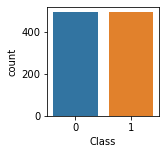

In [83]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.countplot('Class', data=under_df, ax=ax)

In [85]:
X_train, X_test, y_train, y_test = mysplit(under_df)
X_train_NearMiss, y_train_NearMiss = NearMiss().fit_resample(X_train, y_train) # dataframe
X_test_NearMiss, y_test_NearMiss   = NearMiss().fit_resample(X_test, y_test)

print(X_train_NearMiss.shape)
print(X_test_NearMiss.shape)


(688, 29)
(296, 29)


Accuracy:0.962838, Precision:0.963028, Recall:0.962838, F1:0.962834
[[144   4]
 [  7 141]]
202 202 201


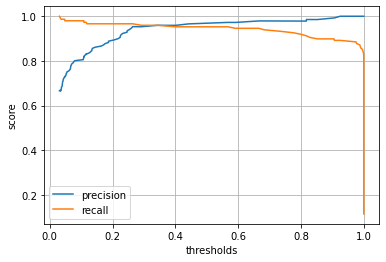

32 32 32


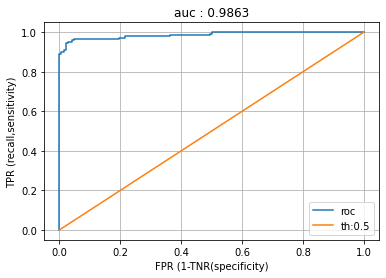

In [87]:
lr = LogisticRegression(random_state = 100)
lr.fit(X_train_NearMiss,y_train_NearMiss)
pred_lr = lr.predict(X_test_NearMiss)
proba_lr = lr.predict_proba(X_test_NearMiss)
myscore(y_test_NearMiss, pred_lr, proba_lr, pr_curve=1, auc_curve=1)

In [88]:
print(classification_report(y_test_NearMiss, pred_lr))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       148
           1       0.97      0.95      0.96       148

    accuracy                           0.96       296
   macro avg       0.96      0.96      0.96       296
weighted avg       0.96      0.96      0.96       296



### 오버샘플링 -> 유사데이터 만들기 / 복제X

In [91]:
from imblearn.over_sampling import SMOTE
df_X = df.iloc[:, :-1]
df_y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = mysplit(df)

smote = SMOTE(random_state=100)
print('SMOTE 적용 전 X_train ', X_train.shape, y_train.shape)
X_train_over, y_train_over = SMOTE(random_state=100).fit_resample(X_train, y_train)
print('SMOTE 적용 후 X_train_over: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 y_train_over:\n', pd.Series(y_train_over).value_counts())


SMOTE 적용 전 X_train  (199364, 29) (199364,)
SMOTE 적용 후 X_train_over:  (398040, 29) (398040,)
SMOTE 적용 후 y_train_over:
 0    199020
1    199020
Name: Class, dtype: int64


Accuracy:0.973163, Precision:0.527492, Recall:0.935971, F1:0.545162
[[83017  2278]
 [   15   133]]
77671 77671 77670


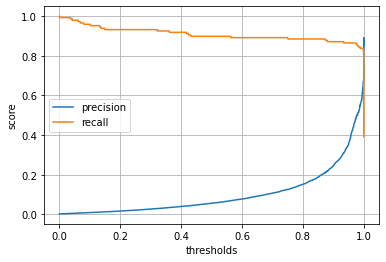

1728 1728 1728


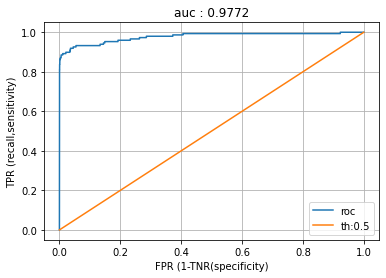

In [92]:
lr = LogisticRegression(random_state = 100)
lr.fit(X_train_over,y_train_over)
pred_lr = lr.predict(X_test)
proba_lr = lr.predict_proba(X_test)
myscore(y_test, pred_lr, proba_lr, pr_curve=1, auc_curve=1)

In [94]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.90      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.97      0.98     85443



### 언더샘플링이 오버샘플링보다 현실에서 위험하다
#### 1억건의 데이터를 버리고 300건만 보고 판단

In [ ]:
#np.log1p('') #amount

In [ ]:
#Minmax, StandardScaler

In [ ]:
#결론 : Time -> 일반/정상 거래 상관 X 

# 연습 ------------------------------------

<AxesSubplot:>

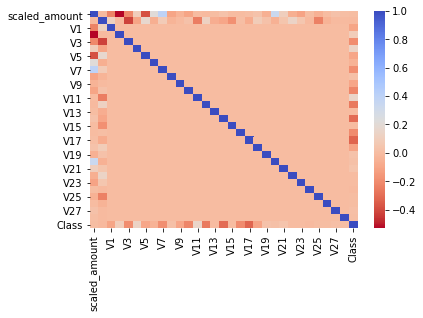

In [29]:
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

In [52]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# df['scaled_amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
# df['scaled_time'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df['scaled_amount'] = np.log1p(df['Amount'])
df['scaled_time'] = np.log1p(df['Time'])

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)


df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,5.014760,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1.305626,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,5.939276,0.693147,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,4.824306,0.693147,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,4.262539,1.098612,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [57]:

lr = LogisticRegression(random_state=100)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_df_X, pca_df_y, test_size=0.2, random_state=100)
lr.fit(X_train_pca, y_train_pca)
pred = lr.predict(X_test_pca)
proba = lr.predict_proba(X_test_pca)
myscore(y_test_pca, pred, proba)


Accuracy:0.998596, Precision:0.840329, Recall:0.656127, F1:0.713934
[[56852    14]
 [   66    30]]


In [56]:
dt = DecisionTreeClassifier(random_state=100)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_df_X, pca_df_y, test_size=0.2, random_state=100)
dt.fit(X_train_pca, y_train_pca)
pred = dt.predict(X_test_pca)
proba = dt.predict_proba(X_test_pca)
myscore(y_test_pca, pred, proba)


Accuracy:0.998157, Precision:0.727283, Recall:0.739100, F1:0.733041
[[56811    55]
 [   50    46]]


In [58]:
n_split_num = 5
scores = []
#kfold = KFold(n_splits=n_split_num, shuffle=False)
kfold = KFold(n_splits=n_split_num, shuffle=True, random_state=30)
for train_index, test_index in kfold.split(df):
    print('Train:', len(train_index), 'Test:', len(test_index))
    X_train, X_test = df.iloc[train_index, :-1], df.iloc[test_index, :-1]
    y_train, y_test = df.iloc[train_index, -1], df.iloc[test_index, -1]
    dt.fit(X_train, y_train)
    pred = dt.predict(X_test)
    #df_score = accuracy_score(y_test, pred)
    df_score = f1_score(y_test, pred, average='macro')
    scores.append(df_score)
    #print('Accuracy: ', round(df_score, 6))
    print('F1: ', round(df_score, 6))
    
print('{:d}회 평균 F1:{:.4f}'.format(n_split_num, np.array(scores).mean()))

Train: 227845 Test: 56962
F1:  0.880505
Train: 227845 Test: 56962
F1:  0.867352
Train: 227846 Test: 56961
F1:  0.873473
Train: 227846 Test: 56961
F1:  0.900733
Train: 227846 Test: 56961
F1:  0.881323
5회 평균 F1:0.8807


In [38]:

from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
myparam = {'max_depth':[1,3,5,7], 'min_samples_split':[1,2,3]}
GCV_model = GridSearchCV(dt, param_grid=myparam, refit=True, cv=5, scoring='f1_macro',verbose=0)
GCV_model.fit(X_train, y_train)
tree_clf = GCV_model.best_estimator_

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [42]:
print(GCV_model.best_score_)
print(GCV_model.best_estimator_)
print(GCV_model.best_params_)

pred = GCV_model.predict(X_test) # <-- CSV파일 넣고 돌리기
df_score = f1_score(y_test,pred, average='macro')
print("F1 : {:.6f}".format(df_score))

0.8628844109924847
DecisionTreeClassifier(max_depth=1, random_state=100)
{'max_depth': 1, 'min_samples_split': 2}
F1 : 0.829282


In [59]:
# train_test_split -> 1회성 셔플, 비율 조절 / StratifiedShufflesplit -> 여러번 섞기 / 비율조절 가능 = KFold와 유사 